In [8]:
import scanpy as sc
import pandas as pd
import harmony
print(harmony.__version__)  # 确认版本
import scanpy.external as scx
import seaborn as sns

0.1.8


In [2]:
#载入数据
adata = sc.read_h5ad("/home/cluster2/tangzefang/yangbo/01_data/mouse_gut_normal_62k.h5ad")
#检查数据
print(adata)
print(adata.obs.columns.tolist()) #细胞样本信息表，来自的组织疾病等
print(adata.var.columns.tolist()) #基因说明书，基因名字id等

AnnData object with n_obs × n_vars = 62121 × 53850
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'
['soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'sel

In [3]:
print("1. 原始数据levels情况:")
print(f"   原始levels数量: {len(adata.obs['cell_type'].cat.categories)}")
print(f"   原始细胞类型示例:")
for i, category in enumerate(adata.obs['cell_type'].cat.categories[:10]):
    print(f"     {i+1}. {category}")

1. 原始数据levels情况:
   原始levels数量: 448
   原始细胞类型示例:
     1. B cell
     2. B cell zone reticular cell
     3. Bergmann glial cell
     4. CD103-positive dendritic cell
     5. CD141-positive myeloid dendritic cell
     6. CD1c-positive myeloid dendritic cell
     7. CD4-positive, alpha-beta T cell
     8. CD4-positive, alpha-beta memory T cell
     9. CD4-positive, alpha-beta thymocyte
     10. CD8-positive, alpha-beta T cell


清理前levels数量: 448
清理后levels数量: 45


/home/cluster2/tangzefang/yangbo/miniconda3/envs/jupyter/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 53850 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


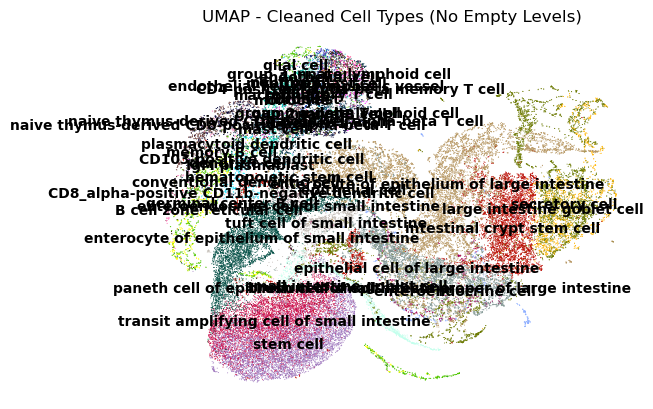

<Figure size 640x480 with 0 Axes>

In [4]:
#方法1：先清理levels，再计算UMAP（推荐）
# -------------------------------
# 1. 复制数据并清理levels
import matplotlib.pyplot as plt
adata_clean = adata.copy()
adata_clean.obs['cell_type'] = adata_clean.obs['cell_type'].astype(str).astype('category')

print(f"清理前levels数量: {len(adata.obs['cell_type'].cat.categories)}")
print(f"清理后levels数量: {len(adata_clean.obs['cell_type'].cat.categories)}")

# 2. 计算UMAP（使用清理后的数据）
sc.pp.neighbors(adata_clean, n_neighbors=15, n_pcs=25)
sc.tl.umap(adata_clean)

# 3. 绘制UMAP（现在图例只显示实际存在的细胞类型）
sc.pl.umap(adata_clean, color=['cell_type'], 
           title='UMAP - Cleaned Cell Types (No Empty Levels)',
           frameon=False, legend_loc='on data')
plt.savefig('umap_cleaned_levels.png', dpi=300, bbox_inches='tight')
plt.show()


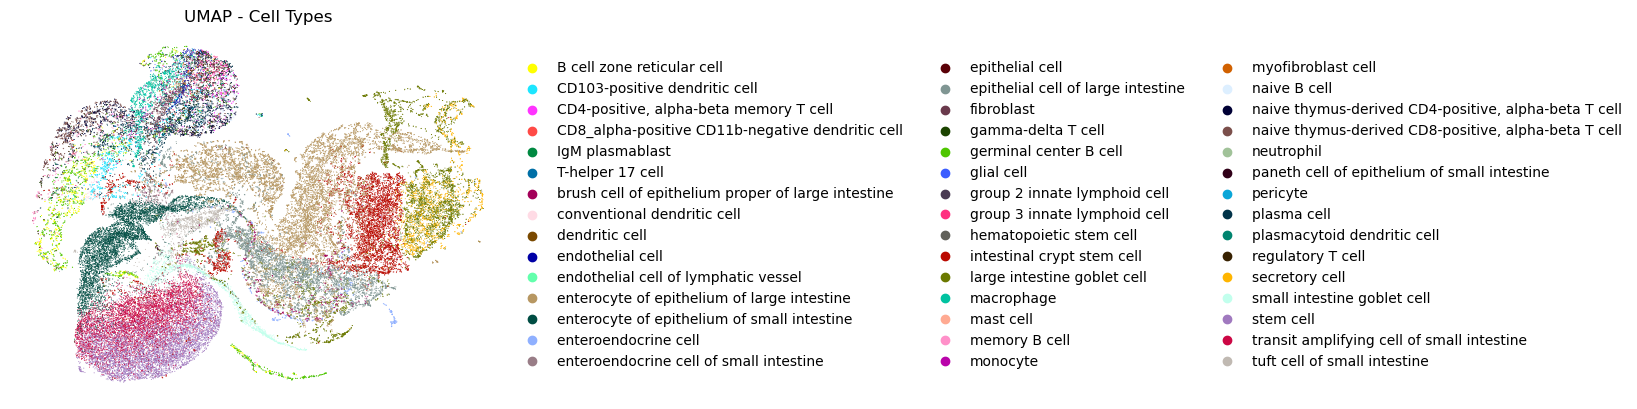

<Figure size 640x480 with 0 Axes>

In [5]:
#图例更改
sc.pl.umap(adata_clean, color=['cell_type'], 
           title='UMAP - Cell Types',
           frameon=False,
           legend_loc='right margin')  # 在右侧显示图例
plt.savefig('umap_right_legend.png', dpi=300, bbox_inches='tight')
plt.show()

     n_genes_by_counts  total_counts  mt_counts  pct_counts_mt
0-0               1301        3640.0       39.0       1.071429
1-0               1753        5173.0       66.0       1.275855
2-0               1169        2135.0       35.0       1.639344
3-0                861        1786.0       26.0       1.455767
4-0               1142        3422.0       33.0       0.964348

线粒体比例统计:
count    62121.000000
mean         2.361463
std          3.996435
min          0.000000
25%          0.000000
50%          0.012252
75%          4.741897
max         37.213783
Name: pct_counts_mt, dtype: float64

详细统计:
平均值 (mean): 324,166.50
中位数 (median): 13,641.00
最小值 (min): 909.00
最大值 (max): 43,478,356.00
标准差 (std): 760,076.50
25% 分位数: 11,788.00
75% 分位数: 295,275.00

n_genes_by_counts 统计:
count    62121.000000
mean      2973.930941
std       1446.501759
min        300.000000
25%       1881.000000
50%       2891.000000
75%       3853.000000
max       8810.000000
Name: n_genes_by_counts, dtype: float64

==

Text(0, 0.5, 'pct_counts_mt (%)')

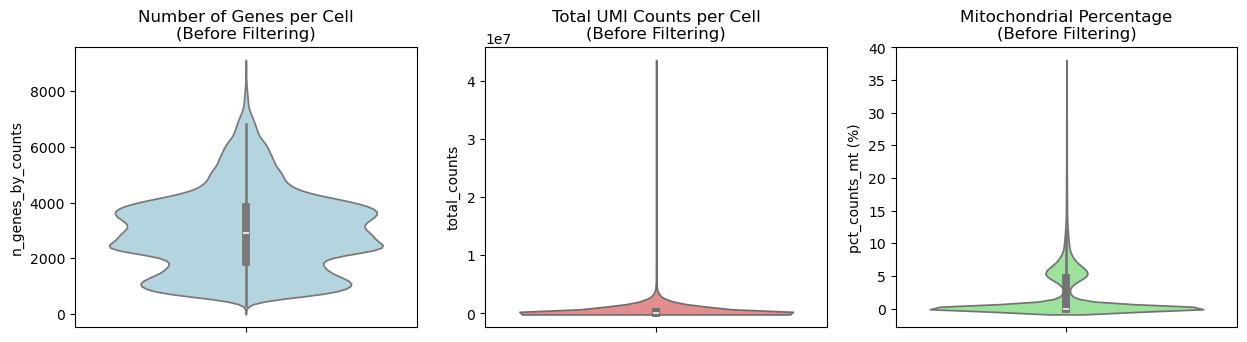

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 计算线粒体比例 - 用你的方法
# -------------------------------
mt_gene_mask = adata_clean.var["feature_name"].str.lower().str.startswith("mt-")
adata_clean.obs["mt_counts"] = adata_clean[:, mt_gene_mask].X.sum(axis=1).A1
adata_clean.obs["total_counts"] = adata_clean.X.sum(axis=1).A1
adata_clean.obs["pct_counts_mt"] = adata_clean.obs["mt_counts"] / adata_clean.obs["total_counts"] * 100
adata_clean.obs["n_genes_by_counts"] = (adata_clean.X > 0).sum(axis=1).A1

print(adata_clean.obs[["n_genes_by_counts", "total_counts", "mt_counts", "pct_counts_mt"]].head())

# 查看线粒体比例统计
print("\n线粒体比例统计:")
print(adata_clean.obs["pct_counts_mt"].describe())

#查看total_count的比例

mean_counts = adata_clean.obs["total_counts"].mean()
median_counts = adata_clean.obs["total_counts"].median()
min_counts = adata_clean.obs["total_counts"].min()
max_counts = adata_clean.obs["total_counts"].max()
std_counts = adata_clean.obs["total_counts"].std()

print(f"\n详细统计:")
print(f"平均值 (mean): {mean_counts:,.2f}")
print(f"中位数 (median): {median_counts:,.2f}")
print(f"最小值 (min): {min_counts:,.2f}")
print(f"最大值 (max): {max_counts:,.2f}")
print(f"标准差 (std): {std_counts:,.2f}")
print(f"25% 分位数: {adata_clean.obs['total_counts'].quantile(0.25):,.2f}")
print(f"75% 分位数: {adata_clean.obs['total_counts'].quantile(0.75):,.2f}")

print("\nn_genes_by_counts 统计:")
print(adata_clean.obs["n_genes_by_counts"].describe())

# 先绘制筛选前的QC图
print("\n=== 筛选前的QC分布 ===")
plt.figure(figsize=(15, 8))

# 筛选前的图
plt.subplot(2, 3, 1)
sns.violinplot(y=adata_clean.obs['n_genes_by_counts'], color='lightblue')
plt.title('Number of Genes per Cell\n(Before Filtering)')
plt.ylabel('n_genes_by_counts')

plt.subplot(2, 3, 2)
sns.violinplot(y=adata_clean.obs['total_counts'], color='lightcoral')
plt.title('Total UMI Counts per Cell\n(Before Filtering)')
plt.ylabel('total_counts')

plt.subplot(2, 3, 3)
sns.violinplot(y=adata_clean.obs['pct_counts_mt'], color='lightgreen')
plt.title('Mitochondrial Percentage\n(Before Filtering)')
plt.ylabel('pct_counts_mt (%)')


筛选前细胞数: 62121
筛选后细胞数: 37134
过滤掉的细胞数: 24987
保留比例: 59.8%

筛选后n_genes_by_counts统计:
count    37134.000000
mean      2530.720418
std       1077.679831
min        500.000000
25%       1543.000000
50%       2614.000000
75%       3459.000000
max       5240.000000
Name: n_genes_by_counts, dtype: float64

筛选后total_counts统计:
count    37134.000000
mean     10330.469727
std       4962.998535
min       1002.000000
25%       5721.000000
50%      12417.000000
75%      13520.000000
max      24975.000000
Name: total_counts, dtype: float64


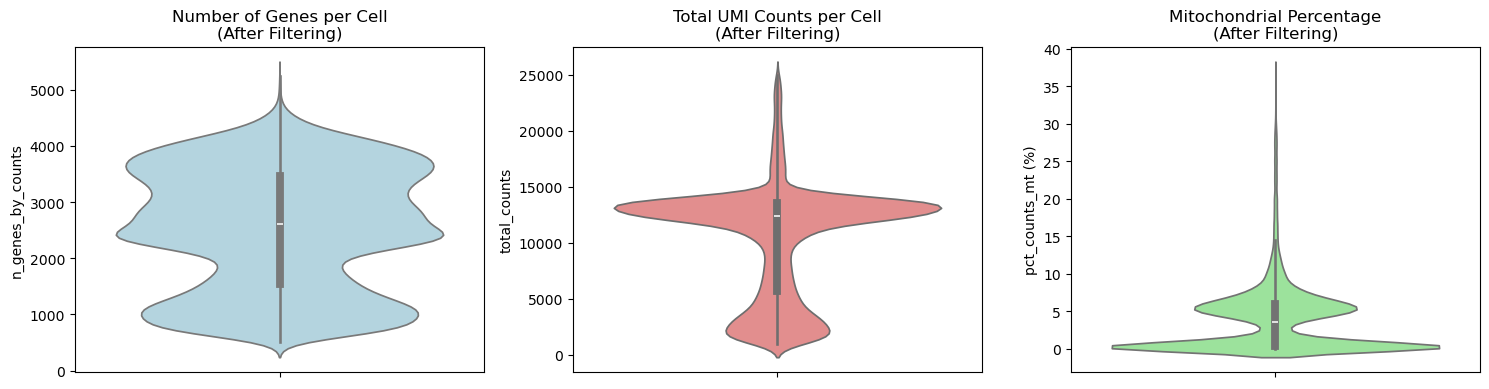

In [21]:
# 直接使用你的计算结果进行筛选
# -------------------------------
min_genes = 500
max_genes = 6000
min_counts = 1000
max_counts = 25000
max_mt = 10  # 百分比

# 筛选前的细胞数
print(f"\n筛选前细胞数: {adata_clean.n_obs}")

# 应用筛选条件 - 使用你自己计算的pct_counts_mt
adata_qc = adata_clean[
    (adata_clean.obs["n_genes_by_counts"] >= min_genes) &
    (adata_clean.obs["n_genes_by_counts"] <= max_genes) &
    (adata_clean.obs["total_counts"] >= min_counts) &
    (adata_clean.obs["total_counts"] <= max_counts) 
].copy()

print(f"筛选后细胞数: {adata_qc.n_obs}")
print(f"过滤掉的细胞数: {adata.n_obs - adata_qc.n_obs}")
print(f"保留比例: {adata_qc.n_obs/adata.n_obs*100:.1f}%")

# 查看筛选后的统计信息
print("\n筛选后n_genes_by_counts统计:")
print(adata_qc.obs["n_genes_by_counts"].describe())

print("\n筛选后total_counts统计:")
print(adata_qc.obs["total_counts"].describe())

# 绘制筛选后的QC图
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.violinplot(y=adata_qc.obs['n_genes_by_counts'], color='lightblue')
plt.title('Number of Genes per Cell\n(After Filtering)')
plt.ylabel('n_genes_by_counts')

plt.subplot(1, 3, 2)
sns.violinplot(y=adata_qc.obs['total_counts'], color='lightcoral')
plt.title('Total UMI Counts per Cell\n(After Filtering)')
plt.ylabel('total_counts')

plt.subplot(1, 3, 3)
sns.violinplot(y=adata_qc.obs['pct_counts_mt'], color='lightgreen')
plt.title('Mitochondrial Percentage\n(After Filtering)')
plt.ylabel('pct_counts_mt (%)')

plt.tight_layout()
plt.savefig('qc_after_filtering.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# 运行PCA，保留50个主成分
sc.tl.pca(adata_qc, n_comps=50, svd_solver="arpack")

# 确认PCA结果已经存储
print(adata_qc.obsm.keys())  # 这应该输出 'X_pca'

KeysView(AxisArrays with keys: X_pca, X_umap)


In [23]:
#去除批次效应
sc.pp.combat(adata_qc, key='batch')

Found 30098 genes with zero variance.


/home/cluster2/tangzefang/yangbo/miniconda3/envs/jupyter/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:343: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/home/cluster2/tangzefang/yangbo/miniconda3/envs/jupyter/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:343: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


/home/cluster2/tangzefang/yangbo/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


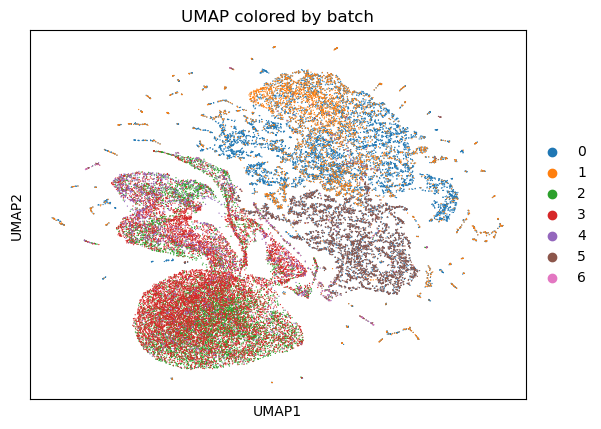

In [24]:
# 使用UMAP进行降维可视化
sc.pp.neighbors(adata_qc, n_neighbors=15, n_pcs=50)  # 使用前50个主成分
sc.tl.umap(adata_qc)

# 查看UMAP图，按批次着色
sc.pl.umap(adata_qc, color='batch', title="UMAP colored by batch")

/home/cluster2/tangzefang/yangbo/miniconda3/envs/jupyter/lib/python3.10/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


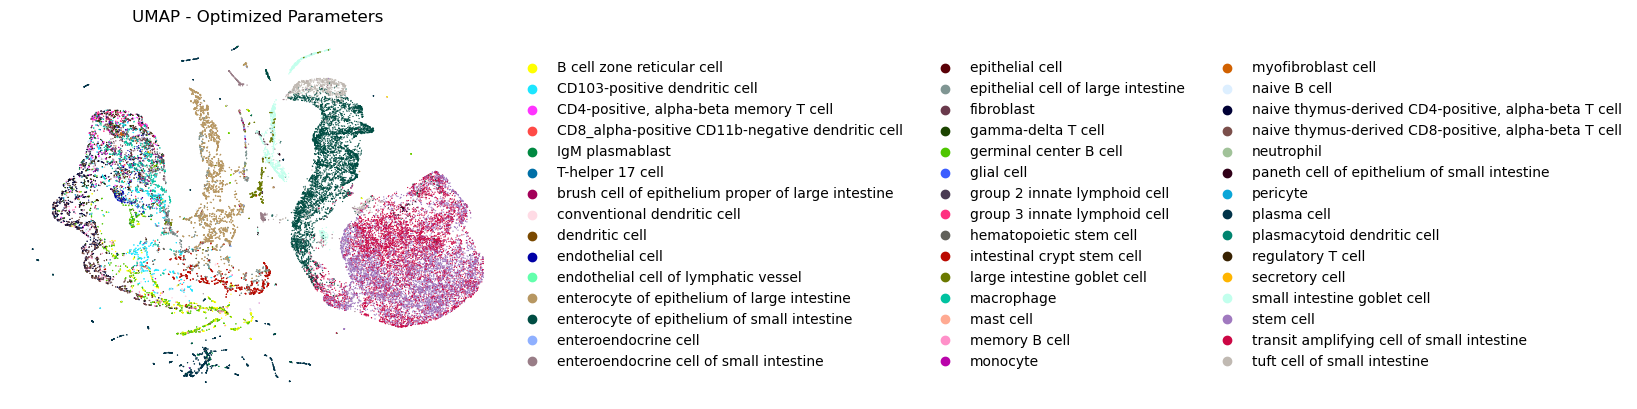

<Figure size 640x480 with 0 Axes>

In [25]:
#去批次效应之后umap图cluster分清
sdata_inte = adata_qc.copy() 

n_PCs, umap_n_neighbors, umap_n_pcs, min_dist, spread_t = [50, 50, 30, 0.01, 5] 
pc_feature = 'X_pca'

sc.pp.neighbors(sdata_inte, n_neighbors=umap_n_neighbors, n_pcs=umap_n_pcs, use_rep=pc_feature)
sc.tl.umap(sdata_inte, min_dist=min_dist, spread=spread_t)  # 修正参数名

sc.pl.umap(sdata_inte, color=['cell_type'], 
           title='UMAP - Optimized Parameters',
           frameon=False, legend_loc='right margin') 
plt.savefig('umap_optimized.png', dpi=300, bbox_inches='tight')
plt.show()


